In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from puzzle_solver import plot
from puzzle_solver.tile_detector import detect_tiles
import scipy
from scipy.signal import find_peaks, find_peaks_cwt

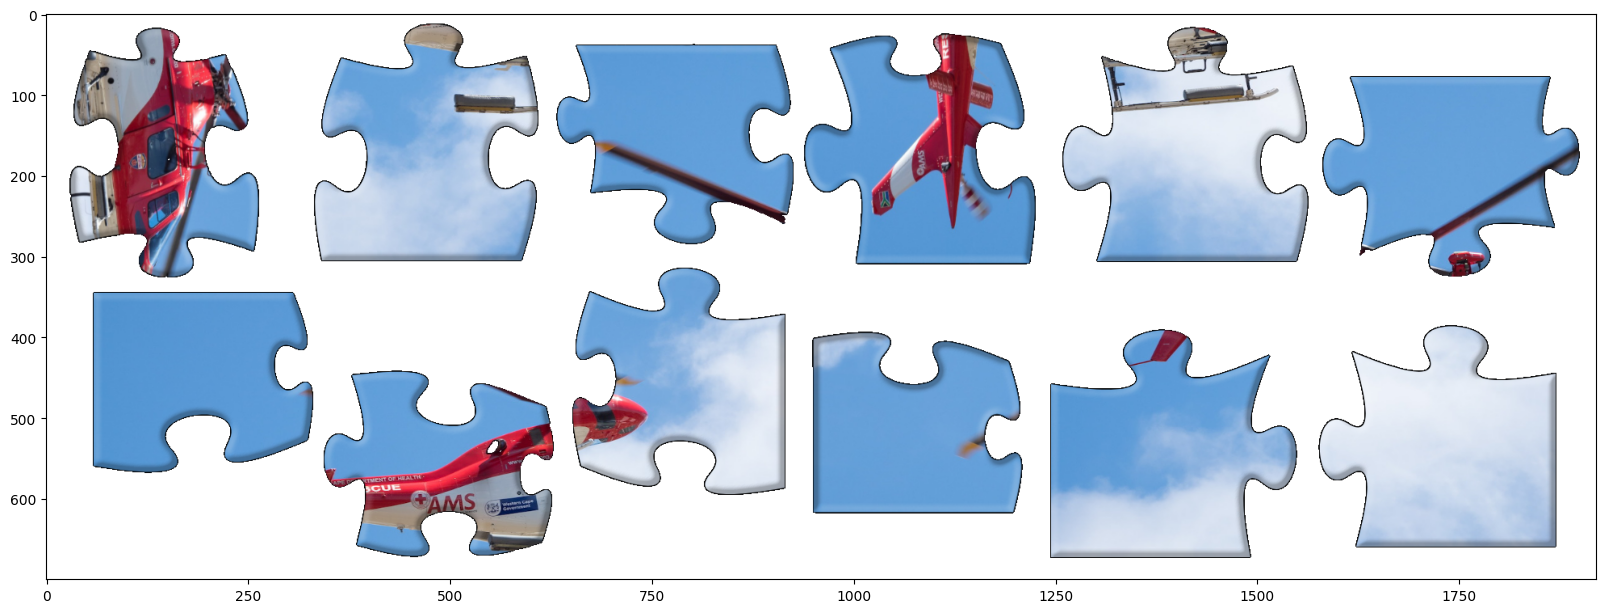

In [50]:
img = cv2.imread("../samples/helico3.png")
plot(img, figsize=(20,10))

In [3]:
boxes, centroids, num_labels, labels = detect_tiles(img)

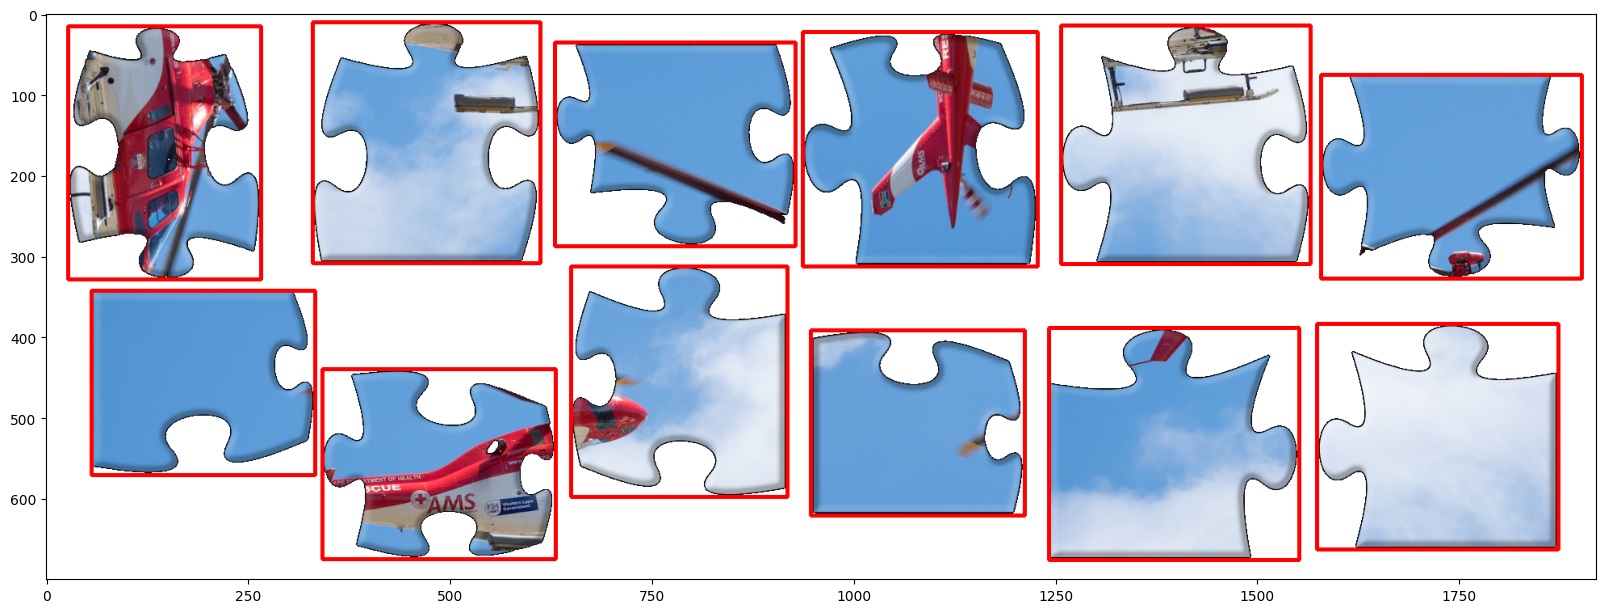

In [4]:
output = img.copy()
for box in np.array(boxes)[1:]:
    cv2.rectangle(output, box[0], box[1], (0, 0, 255), 3)
plot(output, figsize=(20,10))

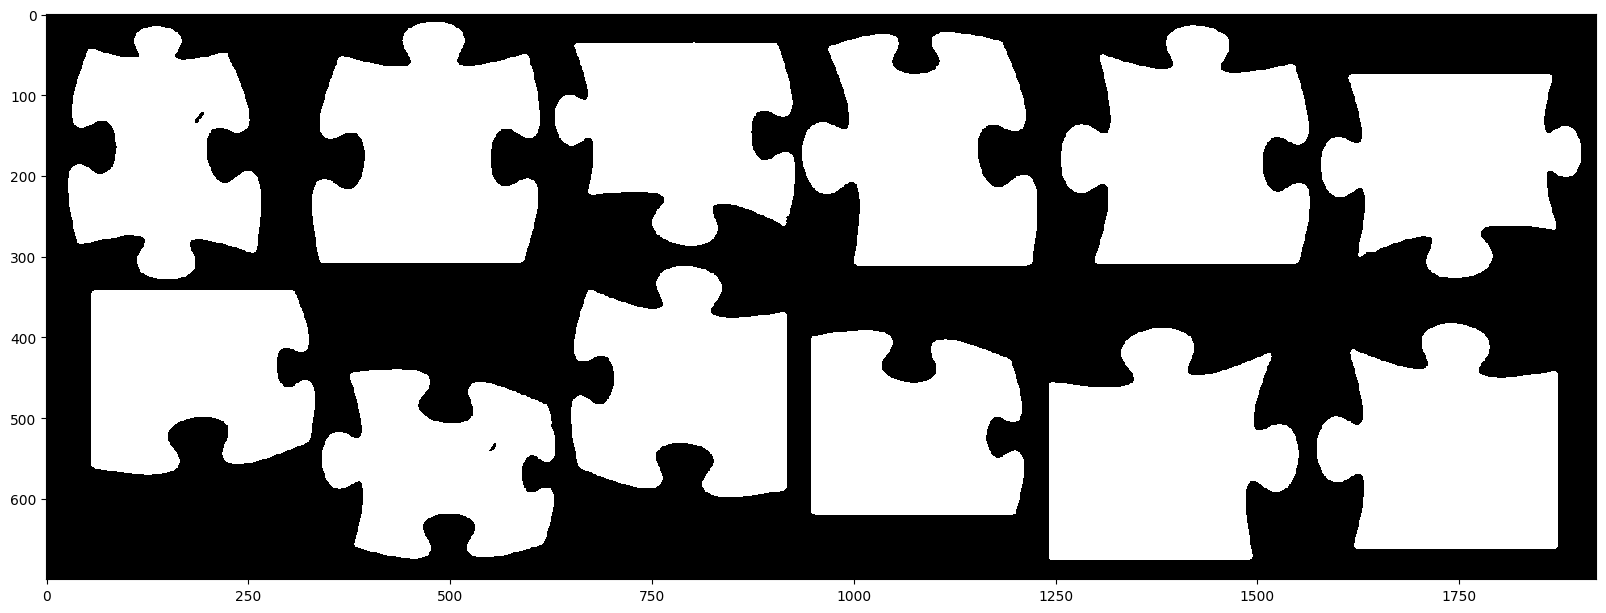

In [5]:
labels_image = np.uint8(labels>0)
plot(labels_image, figsize=(20,10))

number of puzzle pieces : 12


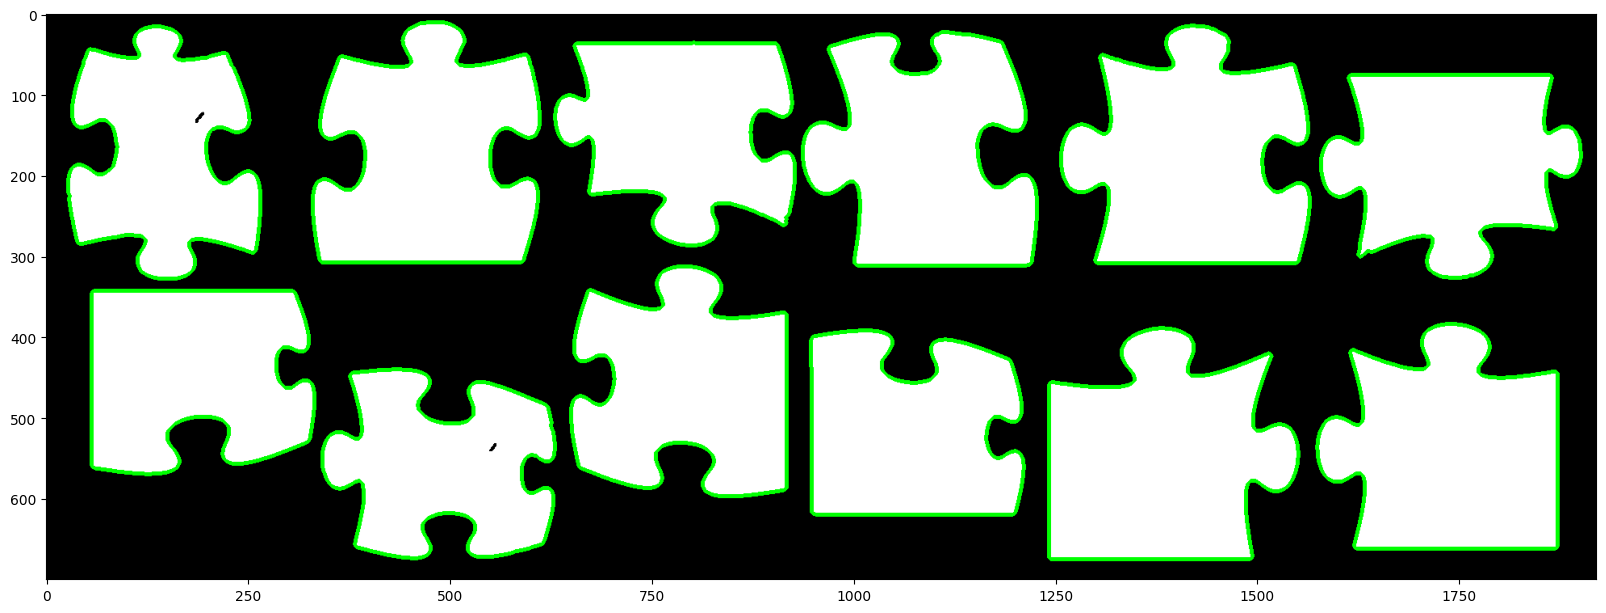

In [6]:
# Get contours
"""contours est une liste de liste où chaque liste correspond à un contour et chaque sous-liste est composée de deux éléments et correspond à un pixel"""
contours, hierarchy = cv2.findContours(labels_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print("number of puzzle pieces :", len(contours))

## Draw contours
labels_image_cop = cv2.cvtColor(labels_image.copy()*255, cv2.COLOR_GRAY2BGR)
cv2.drawContours(labels_image_cop, contours, -1, (0, 255, 0), 3)
plot(labels_image_cop, figsize=(20,10))

In [7]:
# Get the moments
mu = [None]*len(contours)
for i in range(len(contours)):
    mu[i] = cv2.moments(contours[i])
# Get the mass centers
mc = [None]*len(contours)
for i in range(len(contours)):
    # add 1e-5 to avoid division by zero
    mc[i] = (mu[i]['m10'] / (mu[i]['m00'] + 1e-5), mu[i]['m01'] / (mu[i]['m00'] + 1e-5))

new_centroids = np.array(mc)

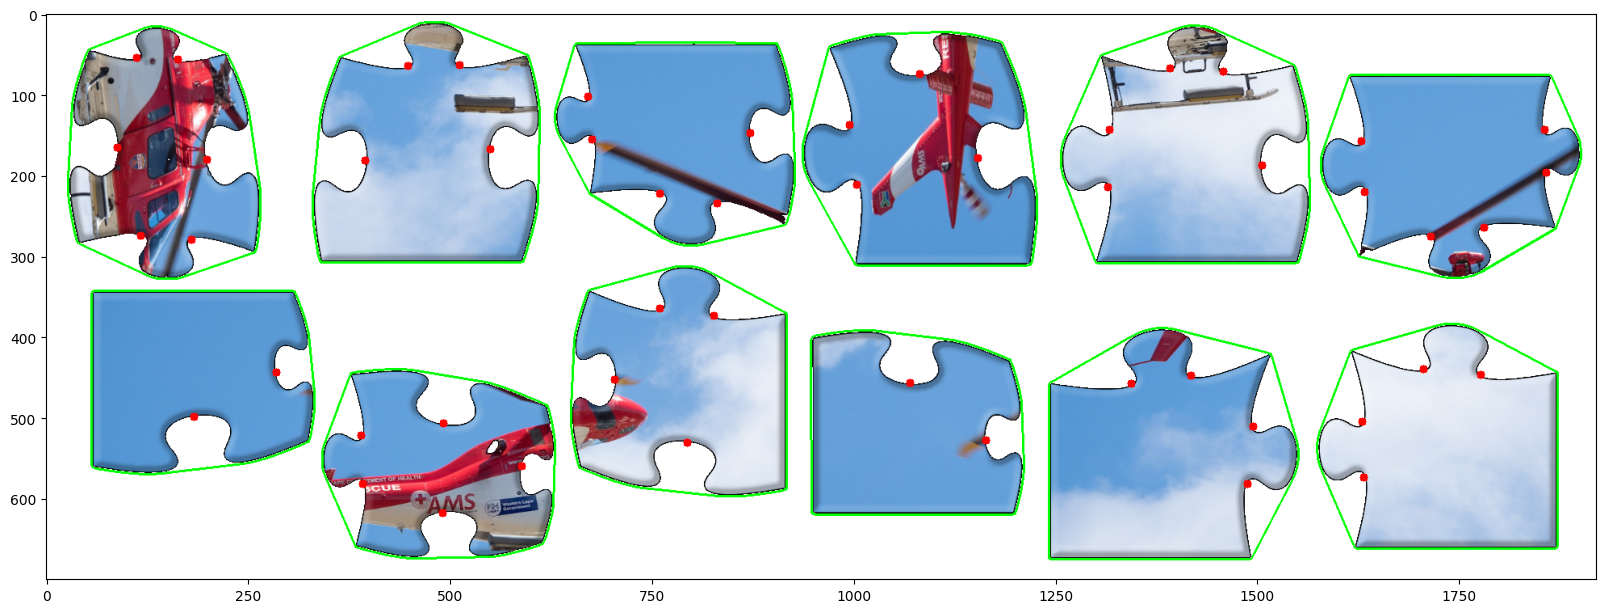

In [8]:
contours_image = img.copy()
lock_points = []
defect_start_end = []
for i in range(len(contours)):
    cnt = contours[i]
    hull = cv2.convexHull(cnt, returnPoints=False)
    defects = cv2.convexityDefects(cnt, hull)
    cv2.drawContours(contours_image, [cnt[hull][:,0,:,:]], -1, color=(0, 255, 0), thickness=2)
    defects_size = defects[:,0,3]/256.
    significant_defects = defects_size>defects_size.max()/3

    local_lock_points = []
    local_defect_start_end = []
    for (s,e,f,d) in defects[significant_defects][:,0]:
        local_defect_start_end.append([s,e])
        local_lock_points.append(f)
        cv2.circle(contours_image,tuple(cnt[f][0]),5,[0,0,255],cv2.FILLED)
    lock_points.append(local_lock_points)
    defect_start_end.append(local_defect_start_end)
    

plot(contours_image, figsize=(20,10))

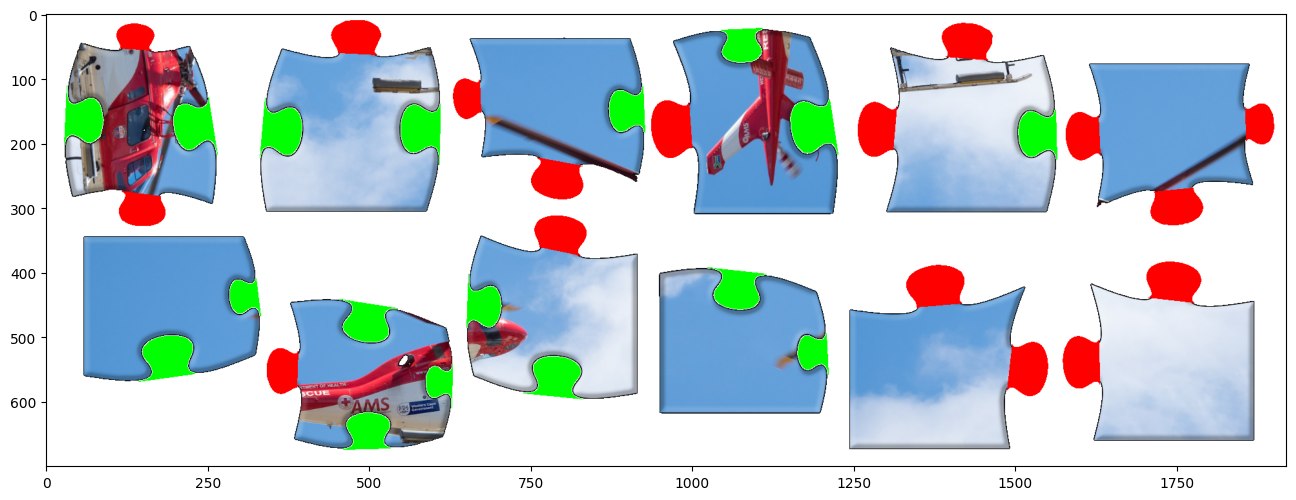

In [9]:
def get_wrapped_contour_section(contour, start_idx, end_idx):
        if start_idx<end_idx:
           return  contour[start_idx:end_idx,:,:]
        return contour[[(idx)%len(contour) for idx in range(start_idx, len(contour)+end_idx)],:,:]

from enum import Enum

class EdgeType(Enum):
    FLAT = 0
    HEAD = 1
    HOLE = -1

contours_image = img.copy()
head_sections = []
hole_sections = []
defect_labels = []
defect_areas = []

for i in range(len(contours)):
    local_lock_points = lock_points[i]
    puzzle_piece_area = cv2.contourArea(contours[i])
    local_head_section = []
    local_hole_section = []
    local_rect_contours = []
    local_head_mask = np.full(len(local_lock_points), fill_value=False)
    local_hole_section = []
    defect_labels.append([EdgeType.FLAT]*len(local_lock_points))
    defect_areas.append([0]*len(local_lock_points))

    for j in range(len(local_lock_points)):
        defect_start = local_lock_points[j]
        defect_end = local_lock_points[(j+1)%len(local_lock_points)]
        contour_section = get_wrapped_contour_section(contours[i], defect_start, defect_end)
        area = cv2.contourArea(contour_section)
        perimeter = cv2.arcLength(contour_section, closed=True)
        circularity = area/perimeter**2
        # cv2.circle(contours_image, (contour_section[0,0]), radius=2, color=(0,255,0), thickness=cv2.FILLED)
        # cv2.circle(contours_image, (contour_section[-1,0]), radius=2, color=(0,255,0), thickness=cv2.FILLED)
        if abs(circularity - 0.25/np.pi)<0.03 and area<0.15*puzzle_piece_area:
            cv2.drawContours(contours_image, [contour_section], -1, color=(0, 0, 255), thickness=cv2.FILLED)
            local_head_section.append(contour_section)
            local_head_mask[j] = True
            local_head_mask[(j+1)%len(local_lock_points)] = True
            defect_labels[-1][j] = EdgeType.HEAD
            defect_labels[-1][(j+1)%len(local_lock_points)] = EdgeType.HEAD
            defect_areas[-1][j] = area
            defect_areas[-1][(j+1)%len(local_lock_points)] = area
            head_sections.append(local_head_section)
    
    for j, (hole_lock_point, is_head, (defect_start, defect_end)) in enumerate(zip(local_lock_points, local_head_mask, defect_start_end[i])):
        if not is_head:
            contour_section = get_wrapped_contour_section(contours[i], defect_start, defect_end)
            cv2.drawContours(contours_image, [contour_section], -1, color=(0, 255, 0), thickness=cv2.FILLED)
            local_hole_section.append(contour_section)
            area = cv2.contourArea(contour_section)
            defect_labels[-1][j] = EdgeType.HOLE
            defect_areas[-1][j] = area
    hole_sections.append(local_hole_section) 



plot(contours_image, figsize=(16,10))

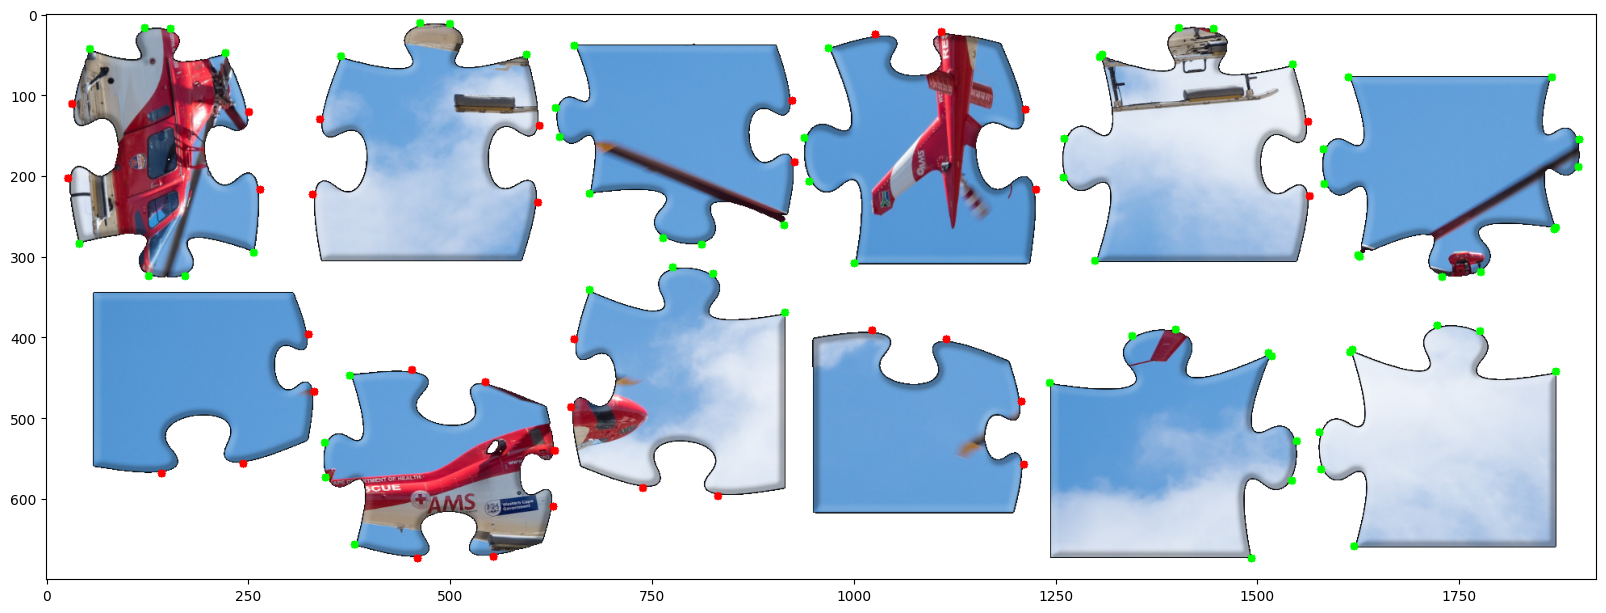

In [10]:
# Check labels

contours_image = img.copy()
i = 0
for piece_defect, piece_label in zip(defect_start_end, defect_labels):
    for (start, end), label in zip(piece_defect, piece_label):
        
        if label == EdgeType.FLAT: # Blue
            color=[255,0,0]
        elif label==EdgeType.HEAD: # Green
            color=[0,255,0]
        elif label==EdgeType.HOLE: # Red
            color=[0,0,255]
        cv2.circle(contours_image, contours[i][start][0], 5, color, cv2.FILLED)
        cv2.circle(contours_image, contours[i][end][0], 5, color, cv2.FILLED)
    
    i+=1

plot(contours_image, figsize=(20,10))

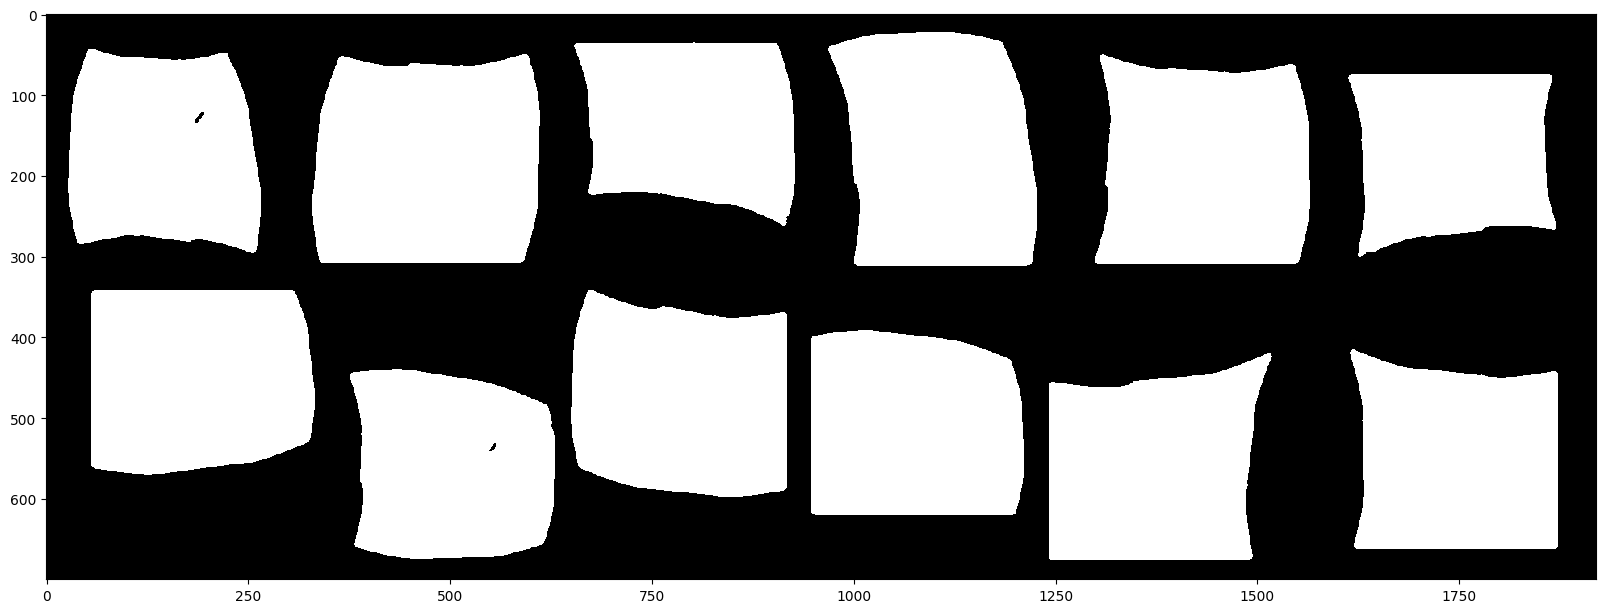

In [11]:
mask = labels_image.copy()
mask[mask>0] = 255

for local_head_section in head_sections:
    cv2.drawContours(mask, local_head_section, -1, color=0, thickness=cv2.FILLED)
for local_hole_section in hole_sections:
    cv2.drawContours(mask, local_hole_section, -1, color=255, thickness=cv2.FILLED)

plot(mask, figsize=(20,10))

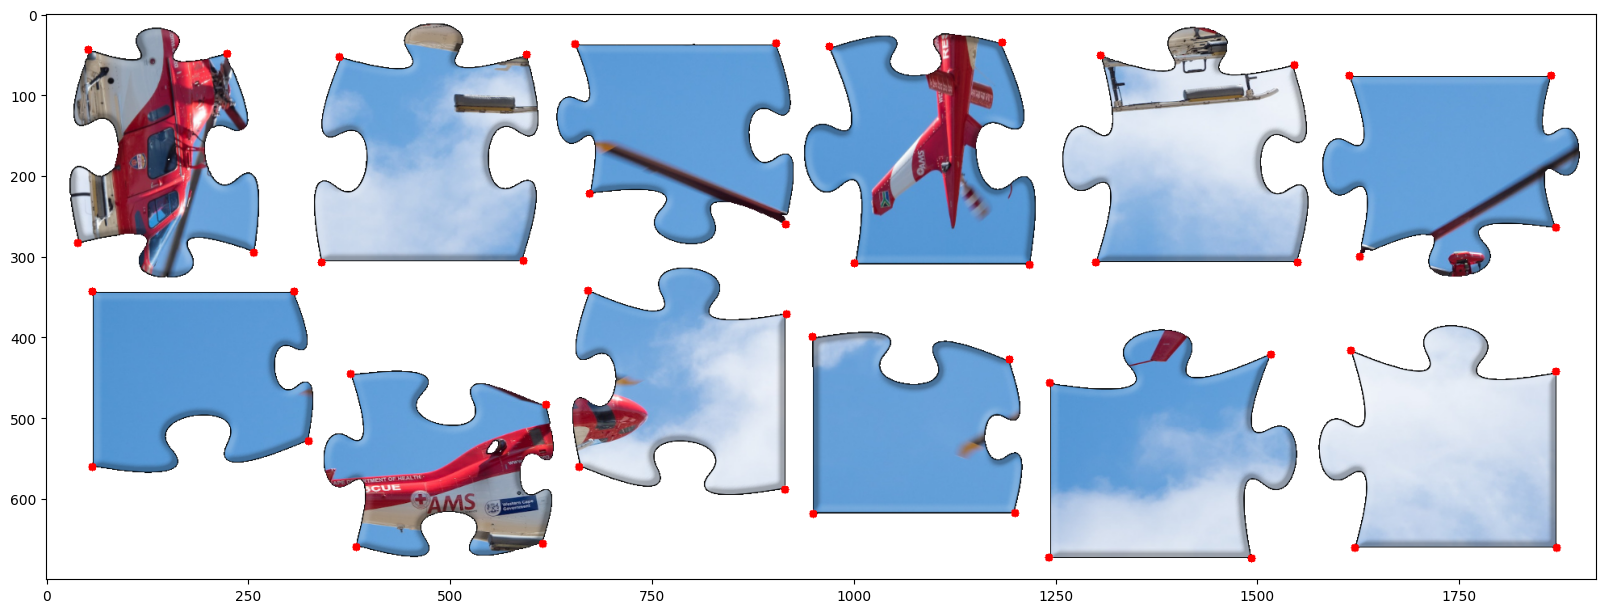

In [12]:
rect_contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
rect_img=img.copy()
corners = []
for rect_contour in rect_contours:
    corners.append([])
    poly = cv2.approxPolyDP(rect_contour, epsilon = 0.1*0.25*cv2.arcLength(rect_contour, True), closed=True)
    for pt in poly[:,0,:]:
        cv2.circle(rect_img, pt, 5, (0, 0, 255), cv2.FILLED)
        corners[-1].append(pt)
corners=np.array(corners)
plot(rect_img, figsize=(20,10))

In [13]:
from dataclasses import dataclass

def rotate(p, angle, origin=(0, 0)):
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    return np.squeeze((R @ (p.T-o.T) + o.T).T)


@dataclass
class PuzzleEdge:
    piece_id: int
    piece_num: int
    coords: np.ndarray
    type: EdgeType
    area: float = 0.
    _norm: np.ndarray | None = None
    _norm_angle: float | None = None

    @property
    def norm(self):
        if self._norm is None:
            norm = self.coords[:,0,:].copy()
            norm -= norm[0]
            angle = np.arctan2(norm[-1,0], norm[-1,1])
            norm = rotate(norm, angle)
            if self.type == EdgeType.HOLE:
                norm[:,0] = - norm[:,0]
            self._norm = norm
            self._norm_angle = angle
        return self._norm
    
    @property
    def angle(self):
        return self._norm_angle
    
    def __repr__(self):
        return f"PuzzleEdge(piece_id={self.piece_id}, piece_num={self.piece_num})"

In [14]:
all_edges = []

def find_contour_idx(contours, point):
    point = np.asarray(point)
    for i in range(len(contours)):
        if (contours[i][:,0,:] == point).all(axis=-1).any():
            return i

for i, piece_corners in enumerate(corners):
    for j in range(len(piece_corners)):
        start_coord = piece_corners[j]
        end_coord = piece_corners[(j+1)%len(piece_corners)]
        contour_idx = find_contour_idx(contours, start_coord)
        contour = contours[contour_idx]

        start_idx = np.argmin(np.linalg.norm(contour[:,0,:]-start_coord, axis=-1))
        end_idx = np.argmin(np.linalg.norm(contour[:,0,:]-end_coord, axis=-1))
        contour_section = get_wrapped_contour_section(contour, start_idx, end_idx+1)

        edge_type = EdgeType.FLAT
        area = 0
        for (defect_start, defect_end), label, area in zip(defect_start_end[contour_idx], defect_labels[contour_idx], defect_areas[contour_idx]):
            if (contour[defect_start] == contour_section).all(axis=-1).any() and (contour[defect_end] == contour_section).all(axis=-1).any():
                edge_type = label
        all_edges.append(PuzzleEdge(piece_id=contour_idx, piece_num=j, coords=contour_section, type=edge_type, area=area))

for left_edge in all_edges:
    for i in range(len(all_edges)//4):
        edges = [e for e in all_edges if e.piece_id==i]
        y = [(e.coords[:,0,1].min(), e.coords[:,0,1].sum()) for e in edges]
        start_piece = edges[y.index(sorted(y)[0])].piece_num
        for e in edges:
            e.piece_num = (e.piece_num - start_piece)%4

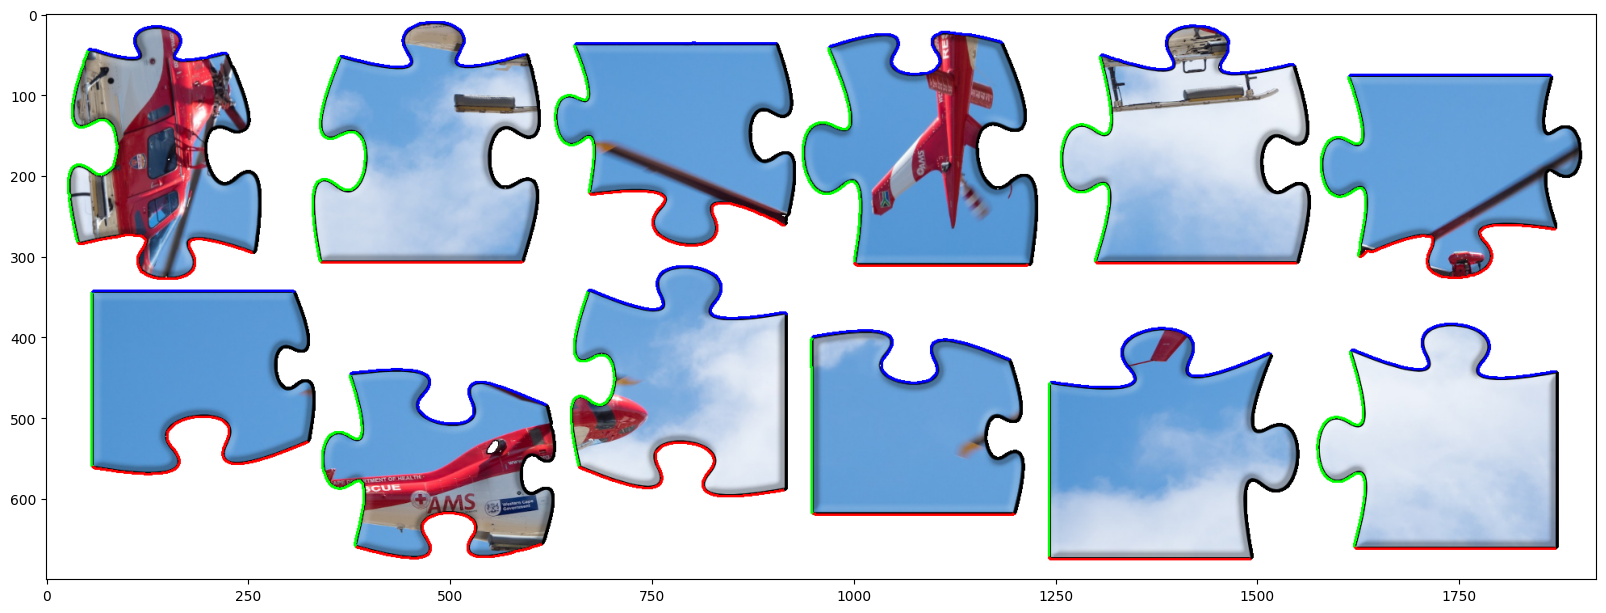

In [16]:
edge_img = img.copy()

for left_edge in all_edges:
    if left_edge.piece_num == 0: # Blue
        color=[255,0,0]
    elif left_edge.piece_num == 1: # Green
        color=[0,255,0]
    elif left_edge.piece_num == 2: # Red
        color=[0,0,255]
    else: color = [0,0,0]
    for i in range(len(left_edge.coords)-1):
        cv2.line(edge_img, left_edge.coords[i,0,:], left_edge.coords[i+1,0,:], color, thickness=2)

plot(edge_img, figsize=(20,10))

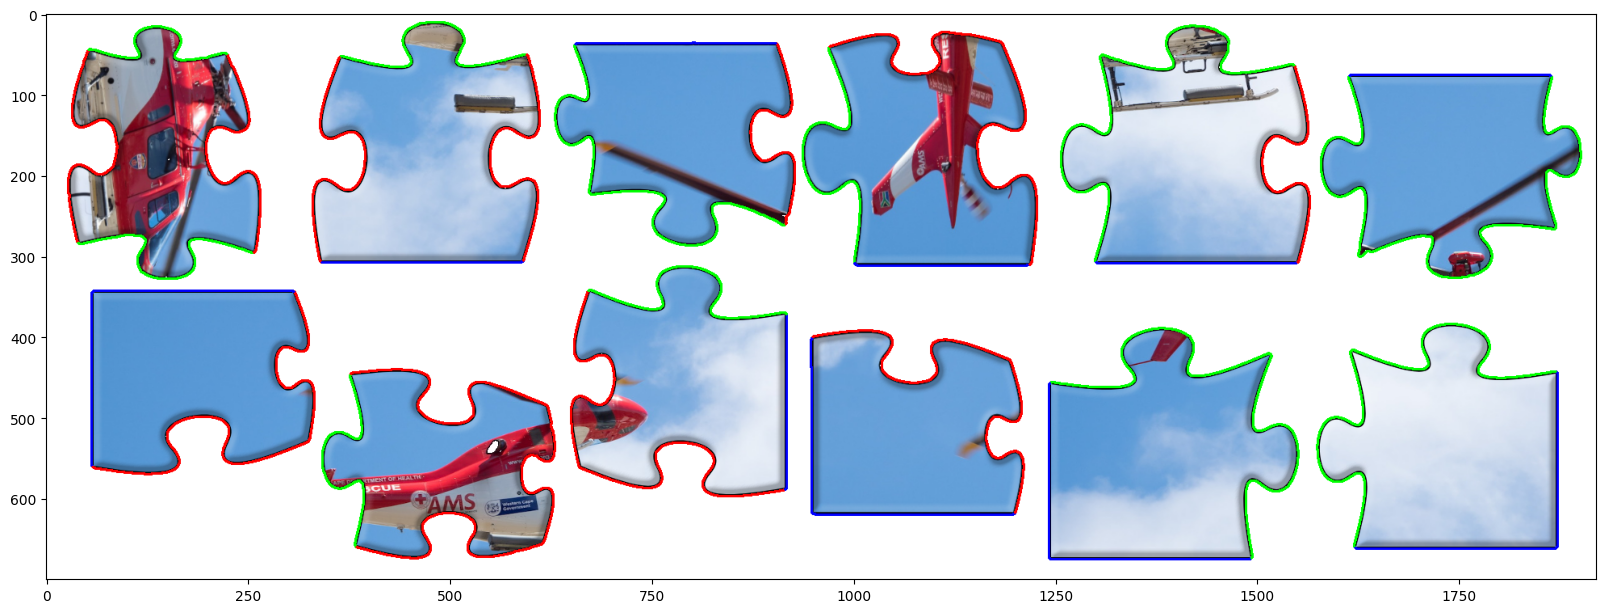

In [17]:
edge_img = img.copy()

for left_edge in all_edges:
    if left_edge.type == EdgeType.FLAT: # Blue
        color=[255,0,0]
    elif left_edge.type==EdgeType.HEAD: # Green
        color=[0,255,0]
    elif left_edge.type==EdgeType.HOLE: # Red
        color=[0,0,255]
    for i in range(len(left_edge.coords)-1):
        cv2.line(edge_img, left_edge.coords[i,0,:], left_edge.coords[i+1,0,:], color, thickness=2)

plot(edge_img, figsize=(20,10))

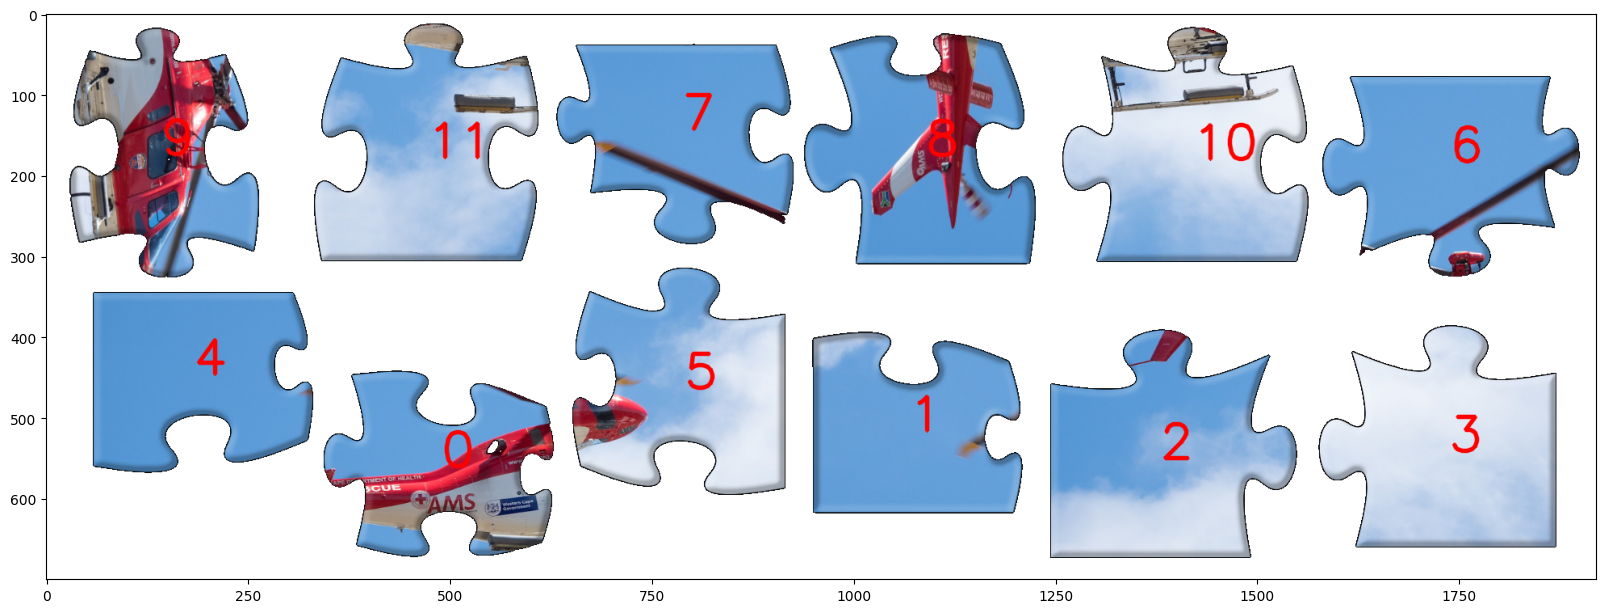

In [19]:
txtimg = img.copy()
font = cv2.FONT_HERSHEY_SIMPLEX
  
org = (50, 50)

fontScale = 2

color = (0,0,255)

thickness = 3
   

# Using cv2.putText() method
for i in range(len(new_centroids)):
    cv2.putText(txtimg, str(i), new_centroids[i].astype(int), font, 
                    fontScale, color, thickness, cv2.LINE_AA)
    
# Displaying the image
plot(txtimg, figsize=(20,10))

In [20]:
heads = [e for e in all_edges if e.type == EdgeType.HEAD]
holes = [e for e in all_edges if e.type == EdgeType.HOLE]

In [21]:
distances = np.zeros((len(heads), len(holes)))

for i, head in enumerate(heads):
    for j, hole in enumerate(holes):
        distances[i,j] = scipy.spatial.distance.cdist(head.norm, hole.norm).min(axis=-1).sum()

In [22]:
matches = []
for i in range(len(distances)):
    head_idx = distances.min(axis=1).argsort()[i]
    hole_pref = distances[head_idx].argsort()
    hole_idx = hole_pref[0]
    for idx in hole_pref:
        if matches!=[] and idx not in np.array(matches)[:,1]:
            hole_idx = idx
            break
    matches.append((head_idx, hole_idx))


In [23]:
matched_edges = [(heads[i], holes[j]) for i,j in matches]

In [94]:
class PuzzlePiece:
    def __init__(self, img, contour, edges, id):

        contour = contour.copy()
        x, y, w, h = cv2.boundingRect(contour)
        cropped = img[y:y+h, x:x+w]
        mask = np.zeros(cropped.shape[:2], dtype=np.uint8)
        contour[:,0,0]-=x
        contour[:,0,1]-=y
        cv2.fillPoly(mask, [contour], 1)
        self.w = w
        self.h = h
        self.x = x
        self.y = y

        self.id = id
        self.contour = contour
        self.img = cv2.bitwise_and(cropped, cropped, mask=mask)
        self.edges = sorted(edges, key=lambda x: x.piece_num)
        self.placed = False
        self.rot = 0
        self.corner = sum(e.type == EdgeType.FLAT for e in self.edges) == 2
        self.border = sum(e.type == EdgeType.FLAT for e in self.edges) >= 1
        self.pos = None
        self.real_pos = None
    
    def rotate(self, n=None):
        if n is None:
            n =self.rot
        for _ in range(n):
            self.img = np.rot90(self.img)
    
    def top_right(self):
        t = self.edges[(3-self.rot)%4].coords[:,0,:] - np.array([self.x, self.y])
        tr = rotate(t, np.pi, origin=(self.w/2, self.h/2)).astype(int)
        if tr[0,1] < tr[-1,1]:
            return tr[-1]
        return tr[0] 

    def bottom_right(self):
        t = self.edges[(3-self.rot)%4].coords[:,0,:] - np.array([self.x, self.y])
        tr = rotate(t, np.pi, origin=(self.w/2, self.h/2)).astype(int)
        if tr[0,0] < tr[-1,0]:
            return tr[-1]
        return tr[0]  


    def place(self, img, pos):
        x,y = pos
        h,w = self.img.shape[:2]
        img[y:y+h,x:x+w] = cv2.add(img[y:y+h,x:x+w], self.img)
        return img
    
    def __repr__(self):
        return f"PuzzlePiece"

In [160]:
pieces: list[PuzzlePiece] = []
for i in range(len(contours)):
    edges = [e for e in all_edges if e.piece_id == i]
    pieces.append(PuzzlePiece(img, contours[i], edges, i))


## Trouver toutes les pièces du bord en haut
puzzle = [[None]*4 for _ in range(3)]
corner = [p for p in pieces if p.corner][3]

piece_num = [e.type for e in corner.edges].index(EdgeType.FLAT)
if corner.edges[-1]==0 and piece_num==0:
    piece_num = 3 
    
corner.rot = (-piece_num) % 4
puzzle[0][0] = corner

piece_source = corner
used_pieces = {corner.id}

for direction in range(4):
    piece_num=0
    if direction%2==0:
        size = len(puzzle[0])
    else:
        size = len(puzzle)
    for piece_num in range(size-1-int(direction==3)): 
        left_edge = [e for e in piece_source.edges if (e.piece_num + piece_source.rot)%4==(3-direction)%4][0]
        possible_edges = []
        for piece in pieces:
            if piece.id == piece_source.id or piece.id in used_pieces:
                continue
            for i in range(len(piece.edges)):
                if (piece.edges[i].type != left_edge.type and piece.edges[i].type != EdgeType.FLAT): # Check HOLE/HEAD & HEAD/HOLE
                    if piece.edges[(i-1)%4].type == EdgeType.FLAT: # Check Flat to the right (because top-left)
                        possible_edges.append(piece.edges[i])
        best_idx = np.argmin([scipy.spatial.distance.cdist(left_edge.norm, possible_edge.norm).min(axis=-1).sum() for possible_edge in possible_edges])
        best_edge = possible_edges[best_idx]
        best_piece = pieces[best_edge.piece_id]
        best_piece.rot = (2 - (best_piece.rot + best_edge.piece_num)  + left_edge.piece_num + piece_source.rot) % 4
        if direction==0:
            puzzle[0][piece_num+1] = best_piece
        elif direction==1:
            puzzle[piece_num+1][len(puzzle[0])-1] = best_piece
        elif direction==2:
            puzzle[len(puzzle)-1][len(puzzle[0])-2-piece_num] = best_piece
        elif direction==3:
            puzzle[len(puzzle)-2-piece_num][0] = best_piece            
        piece_source = best_piece
        used_pieces.add(piece_source.id)



In [161]:
piece_source = puzzle[1][0]

for row_idx in range(1, len(puzzle)-1):
    for piece_num in range(1, len(puzzle[0])-1):
        left_edge = [e for e in piece_source.edges if (e.piece_num + piece_source.rot)%4==3][0]
        possible_edges = []
        for piece in pieces:
            if piece.id == piece_source.id or piece.id in used_pieces:
                continue
            top_edge = [e for e in puzzle[row_idx-1][piece_num].edges  if (e.piece_num + puzzle[row_idx-1][piece_num].rot)%4==2][0]
            if row_idx==len(puzzle)-2:
                bottom_edge = [e for e in puzzle[row_idx+1][piece_num].edges  if (e.piece_num +  puzzle[row_idx+1][piece_num].rot)%4==0][0]
            for i in range(len(piece.edges)):
                if (piece.edges[i].type != left_edge.type): # Check HOLE/HEAD on the left
                    if piece.edges[(i-1)%4].type != top_edge.type: # Check HOLE/HEAD on the top
                        possible_edges.append((piece.edges[i], piece.edges[(i-1)%4], piece.edges[(i+1)%4]))
        d2 = np.array([scipy.spatial.distance.cdist(left_edge.norm, possible_edge[0].norm).min(axis=-1).sum() for possible_edge in possible_edges])
        d1 = np.array([scipy.spatial.distance.cdist(top_edge.norm, possible_edge[1].norm).min(axis=-1).sum() for possible_edge in possible_edges])
        if row_idx==len(puzzle)-2:
            d3 = np.array([scipy.spatial.distance.cdist(bottom_edge.norm, possible_edge[2].norm).min(axis=-1).sum() for possible_edge in possible_edges])
            d2+=d3
        best_idx = np.argmin(d1+d2)
        best_edge = possible_edges[best_idx][0]
        best_piece = pieces[best_edge.piece_id]
        best_piece.rot = (2 - (best_piece.rot + best_edge.piece_num)  + left_edge.piece_num + piece_source.rot) % 4

        puzzle[row_idx][piece_num] = best_piece

        piece_source = best_piece
        used_pieces.add(piece_source.id)

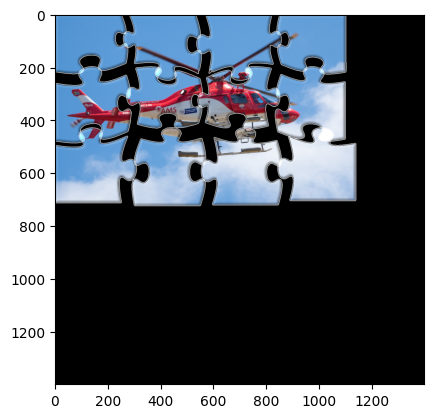

In [162]:
res = np.zeros((img.shape[0]*2, img.shape[0]*2,3), dtype=np.uint8)
delta_y = 0
next_delta_y = 0
for i in range(len(puzzle)):
    delta_x = 0
    for j in range(len(puzzle[0])):
        piece = puzzle[i][j]
        piece.rotate()
        piece.place(res, (delta_x, delta_y))
        delta_x += piece.img.shape[1] - 20  - 20 * (i==1)
        if j == 0:
            next_delta_y = piece.img.shape[0] - 30 - 30 * (i==1)
    delta_y+=next_delta_y

plot(res)


173

Old stuff

In [94]:
pieces[0].coords = [0,0]
for piece in pieces:
    for left_edge in piece.edges:
        if left_edge.type == EdgeType.FLAT:
            pass
        if left_edge.type == EdgeType.HEAD:
            other = [holes[y] for x,y in matches if (heads[x].piece_id==left_edge.piece_id and heads[x].piece_num==left_edge.piece_num)][0]
        elif left_edge.type == EdgeType.HOLE:
            other = [heads[x] for x,y in matches if (holes[y].piece_id==left_edge.piece_id and holes[y].piece_num==left_edge.piece_num)][0]
        next_piece = pieces[other.piece_id]

        # Determine next piece coords
        direction = (left_edge.piece_num + piece.rot)%4
        next_coords = piece.coords.copy()
        if direction==0:
            next_coords[1]+=1
        elif direction==1:
            next_coords[0]-=1
        elif direction==2:
            next_coords[1]-=1
        elif direction==3:
            next_coords[0]+=1
        new_coords = False
        if hasattr(next_piece, "coords"):
            new_coords = True
            if next_piece.coords != next_coords:
                raise ValueError("Impossible, ou erreur dans le code :)")
        next_piece.coords = next_coords

        other_direction = (other.piece_num + next_piece.rot)%4
        next_rot = (2 - other_direction  + direction) % 4 # Maybe ?
        if not new_coords and next_rot != next_piece.rot:
            print(next_piece.id)
            raise ValueError("Impossible rot, ou erreur dans le code :)")
        next_piece.rot = next_rot



AttributeError: 'PuzzlePiece' object has no attribute 'coords'